In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [43]:
def correct_season(df,column,factor,T):
    clone_column = df[column]
    
    df["diff"] = clone_column.diff(periods=T).dropna()
    df["diff_abs"] = df["diff"].apply(np.absolute)
    diff_mean = df["diff_abs"].mean()
    
    threshold_factor = factor 
    anomalies = df.loc[ ~(df["diff"].isnull()) & (df["diff_abs"].dropna() > threshold_factor * diff_mean)]
    
    df["new"] = clone_column

    for i in range(len(anomalies)):
        df_od_curr = df.loc[ df["date_time"] == anomalies.iloc[i]["date_time"] ]
        df_od_prev = df.loc[df_od_curr.index -1]

        od_curr_index = df_od_curr.index[0]

        od_curr = df_od_curr.iloc[0][column]
        od_prev = df_od_prev.iloc[0][column]
        shifter = round(od_curr - od_prev , 2)

        for j in range(0,od_curr_index):
            df.loc[j,"new"] += [shifter]

        # plt.figure(figsize=(10,8))
        # plt.title("Round:"+ str(i+1))
        # plt.plot(df["date_time"],df[column],label = "original")
        # plt.plot(df["date_time"],df["new"],label = "corrected")
        # plt.axhline(y = -11.65, color = "k", linestyle = "--", label="actual min")
        # plt.axhline(y = 11.65, color = "k", linestyle = "--", label="limited max")
        # plt.legend()

    return df["new"]

In [5]:
datetime = pd.DataFrame(pd.date_range(start="12/01/2019 00:00",end="11/30/2020 23:50",freq="10min").rename("date_time"))
# datetime.rename(columns={"0":"date_time"},inplace=True)
datetime

,date_time
0,2019-12-01 00:00:00
1,2019-12-01 00:10:00
2,2019-12-01 00:20:00
3,2019-12-01 00:30:00
4,2019-12-01 00:40:00
...,...
52699,2020-11-30 23:10:00
52700,2020-11-30 23:20:00
52701,2020-11-30 23:30:00
52702,2020-11-30 23:40:00


In [6]:
df = pd.read_csv("water.csv")
df["date_time"] = pd.to_datetime(df["date_time"])
# df.info()
# df

In [7]:
df_train = df.drop(["date","time"],axis=1)

In [8]:
# # df_train = df_train.resample("10T", on="date_time").mean().interpolate(method="time")
my_order = 3
my_s = 10
df_train = df_train.resample("10T",on="date_time").mean().interpolate(method="spline",order=my_order,s=my_s)
df_train.reset_index(inplace=True)
# # df_train

In [9]:
df_train.loc[df_train[df_train["water"] < -11.65].index,"water"] = -11.65
df_train.loc[df_train[df_train["water"] > 11.65].index,"water"] = 11.65

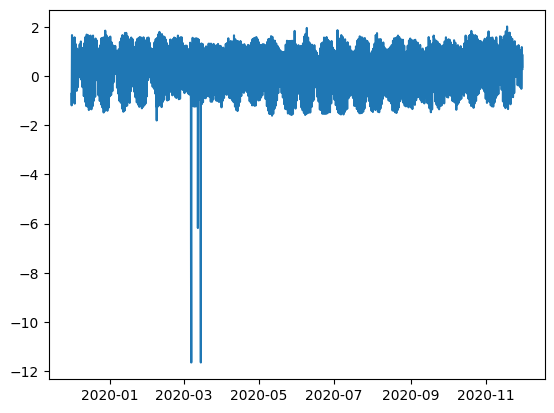

In [10]:
plt.plot(df_train["date_time"],df_train["water"])

In [11]:
start = pd.to_datetime("12/1/2019 00:00:00", format="%m/%d/%Y %H:%M:%S")
end = pd.to_datetime("11/29/2020 23:50:00", format="%m/%d/%Y %H:%M:%S")
filter = (df_train["date_time"] >= start) & (df_train["date_time"] <= end)
df_train = df_train.loc[filter]

In [12]:
df_train.drop(df_train[df_train['date_time'].dt.minute != 0].index, inplace=True)

In [13]:
df_train.reset_index(drop=True, inplace=True)

In [14]:
df_train

,date_time,water
0,2019-12-01 00:00:00,-0.720000
1,2019-12-01 01:00:00,-0.970000
2,2019-12-01 02:00:00,-1.140000
3,2019-12-01 03:00:00,-1.170000
4,2019-12-01 04:00:00,-0.740000
...,...,...
8755,2020-11-29 19:00:00,0.150000
8756,2020-11-29 20:00:00,-0.253705
8757,2020-11-29 21:00:00,-0.464795
8758,2020-11-29 22:00:00,-0.515602


In [15]:
df_train["water_diff"] = df_train["water"].diff(periods=24)

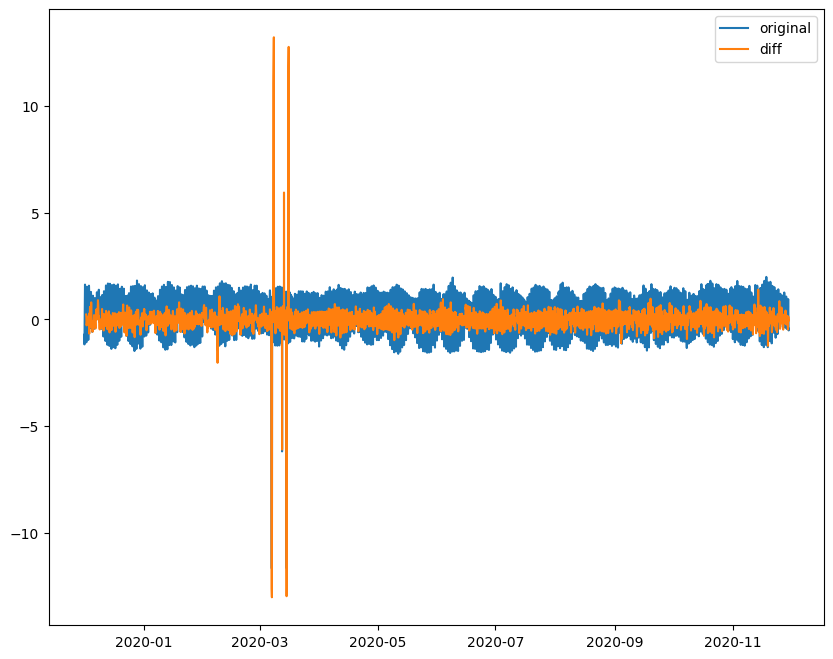

In [16]:
plt.figure(figsize=(10,8))
plt.plot(df_train["date_time"],df_train["water"], label = "original")
plt.plot(df_train["date_time"],df_train["water_diff"], label = "diff")
plt.legend()

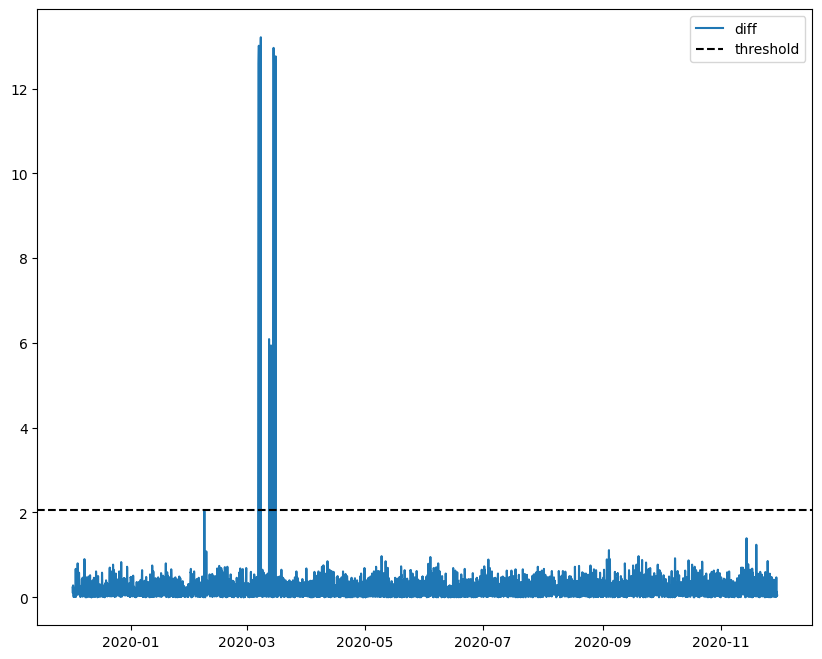

In [41]:
plt.figure(figsize=(10,8))
plt.plot(df_train["date_time"],df_train["water"].diff(periods=24).abs(),label = "diff")
plt.axhline(y = df_train["water"].diff(periods=24).abs().mean() * 7.75, color = "k", linestyle = "--", label="threshold")
plt.legend()

In [ ]:
df_train["water_new"] = correct_season(df_train,"water",7.75,24)

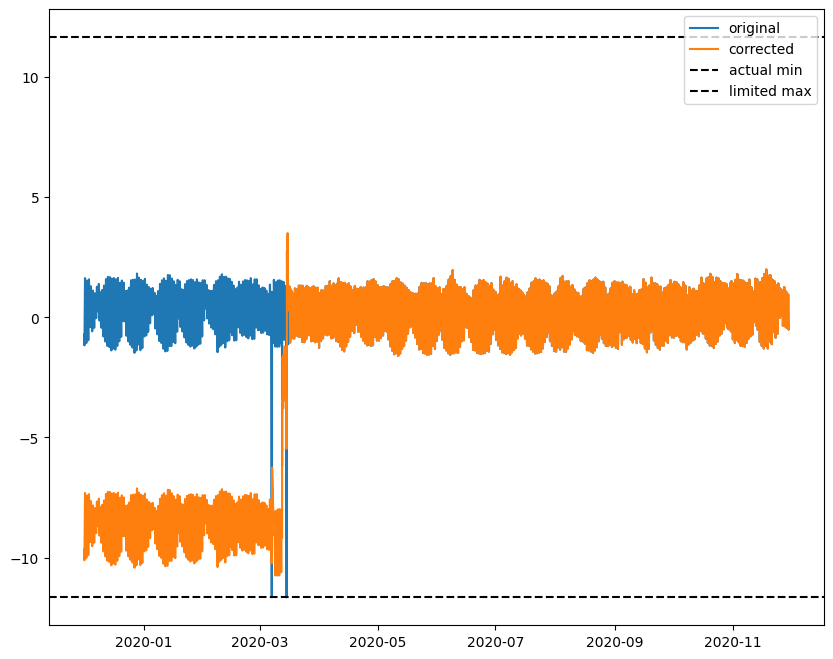

In [45]:
plt.figure(figsize=(10,8))
plt.plot(df_train["date_time"],df_train["water"],label = "original")
plt.plot(df_train["date_time"],df_train["water_new"],label = "corrected")
plt.axhline(y = -11.65, color = "k", linestyle = "--", label="actual min")
plt.axhline(y = 11.65, color = "k", linestyle = "--", label="limited max")
plt.legend()